# 第7章: データベース

[artist.json.gz](data/artist.json.gz)は，オープンな音楽データベース[MusicBrainz](https://musicbrainz.org/)の中で，アーティストに関するものをJSON形式に変換し，gzip形式で圧縮したファイルである．このファイルには，1アーティストに関する情報が1行にJSON形式で格納されている．JSON形式の概要は以下の通りである．

|フィールド|型|内容|例|
|:-----------|:---|:-----|:--|
|id|ユニーク識別子|整数|20660|
|gid|グローバル識別子|文字列|"ecf9f3a3-35e9-4c58-acaa-e707fba45060"|
|name|アーティスト名|文字列|"Oasis"|
|sort_name|アーティスト名（辞書順整列用）|文字列|"Oasis"|
|area|活動場所|文字列|"United Kingdom"|
|aliases|別名|辞書オブジェクトのリスト||
|aliases[].name|別名|文字列|"オアシス"|
|aliases[].sort_name|別名（整列用）|文字列|"オアシス"|
|begin|活動開始日|辞書||
|begin.year|活動開始年|整数|1991|
|begin.month|活動開始月|整数||
|begin.date|活動開始日|整数||
|end|活動終了日|辞書||
|end.year|活動終了年|整数|2009|
|end.month|活動終了月|整数|8|
|end.date|活動終了日|整数|28|
|tags|タグ|辞書オブジェクトのリスト||
|tags[].count|タグ付けされた回数|整数|1|
|tags[].value|タグ内容|文字列|"rock"|
|rating|レーティング|辞書オブジェクト||
|rating.count|レーティングの投票数|整数|13|
|rating.value|レーティングの値（平均値）|整数|86|

artist.json.gzのデータをKey-Value-Store (KVS) およびドキュメント志向型データベースに格納・検索することを考える．KVSとしては，[LevelDB](http://leveldb.org/)，[Redis](http://redis.io/)，[KyotoCabinet](http://fallabs.com/kyotocabinet/)等を用いよ．ドキュメント志向型データベースとして，[MongoDB](http://www.mongodb.org/)を採用したが，[CouchDB](http://couchdb.apache.org/)や[RethinkDB](http://rethinkdb.com/)等を用いてもよい．

In [4]:
!wget -nc http://localhost:8888/notebooks/chapter07/data/artist.json.gz -P ./data/

ファイル `./data/artist.json.gz' はすでに存在するので、取得しません。



In [5]:
# !gunzip ./data/artist.json.gz

In [89]:
import json
from itertools import islice
import pprint as pp

with open('./data/artist.json', 'r') as f:
    for line in islice(f, 3):
        pp.pprint(json.loads(line))

{'ended': True,
 'gid': '8972b1c1-6482-4750-b51f-596d2edea8b1',
 'id': 805192,
 'name': 'WIK▲N',
 'sort_name': 'WIK▲N',
 'tags': [{'count': 1, 'value': 'sillyname'}]}
{'ended': True,
 'gid': 'b4f76788-7e6f-41b7-ac7b-dfb67f66282e',
 'id': 578352,
 'name': 'Gustav Ruppke',
 'sort_name': 'Gustav Ruppke',
 'type': 'Person'}
{'ended': True,
 'gid': '49add228-eac5-4de8-836c-d75cde7369c3',
 'id': 371203,
 'name': 'Pete Moutso',
 'sort_name': 'Moutso, Pete',
 'type': 'Person'}


### LevelIDB install
https://qiita.com/tomotaka_ito/items/60c65dd5261fdfc6e71a
### Plyvel User guide
https://plyvel.readthedocs.io/en/latest/user.html#getting-started

In [184]:
import json
import plyvel

db = plyvel.DB('./work/db', create_if_missing=True)
print(db.closed)   # dbが閉じているかの確認

db.close()
print(db.closed)

False
True


## 60. KVSの構築
Key-Value-Store (KVS) を用い，アーティスト名（name）から活動場所（area）を検索するためのデータベースを構築せよ．

In [174]:
import json
from itertools import islice
import pprint as pp

with open('./data/artist.json', 'r') as f:
    for line in islice(f, 10):
        if 'area' in json.loads(line):
            pp.pprint(json.loads(line))

{'aliases': [{'name': 'Silhouettes', 'sort_name': 'Silhouettes'},
             {'name': 'The Sihouettes', 'sort_name': 'The Sihouettes'}],
 'area': 'United States',
 'begin': {'year': 1956},
 'end': {'year': 1993},
 'ended': True,
 'gid': 'ca3f3ee1-c4a7-4bac-a16a-0b888a396c6b',
 'id': 101060,
 'name': 'The Silhouettes',
 'sort_name': 'Silhouettes, The',
 'type': 'Group'}
{'area': 'United States',
 'ended': True,
 'gender': 'Male',
 'gid': '3e1bd546-d2a7-49cb-b38d-d70904a1d719',
 'id': 1172876,
 'name': 'Al Street',
 'sort_name': 'Street, Al',
 'type': 'Person'}


In [185]:
import json
import plyvel

db = plyvel.DB('./work/db_name2area', create_if_missing=True) 
with open('./data/artist.json', 'r') as f:
    for line in f:
        data = json.loads(line.rstrip())
        if 'area' in data:
            db.put(data['name'].encode(), data['area'].encode())   # encodeが必要

db.close()
if db.closed:
    print('Finished!')

Finished!


In [186]:
import plyvel
from itertools import islice

db = plyvel.DB('./work/db_name2area', create_if_missing=True)
for key, val in islice(db, 20):
    print(key.decode()+'\t'+val.decode())
    
db.close()

!!!	United States
!Action Pact!	United Kingdom
!Bang Elektronika	Canada
!DelaDap	Austria
!Regeringen	Sweden
!T.O.O.H.!	Czech Republic
!Ved	United Kingdom
!ky que	Sankt-Peterburg
"..."	Sweden
"A" Trio	Lebanon
"Alakulttuurin kusipäät"	Finland
"Alpha Wolf Kodi"	Georgia
"Baltic Beach Party" zvaigžņu koris	Latvia
"DD"	United States
"Deadly" Headley Bennett	Jamaica
"Demons"	Sweden
"Evil" Jared Hasselhoff	United States
"Fast" Eddie Smith	United States
"Jesus Christ." (the indie band)	United States
"José José" Gayoso	Paraguay


## 61. KVSの検索
60で構築したデータベースを用い，特定の（指定された）アーティストの活動場所を取得せよ．

In [187]:
%%file src/q61.py

import sys
import plyvel

name = sys.argv[1].encode()

db = plyvel.DB('./work/db_name2area/', create_if_missing=True)
area_info = db.get(name)
if area_info:
    print(area_info.decode())
else:
    print('There is no area information of the artist.')

db.close()

Overwriting src/q61.py


In [188]:
!python ./src/q61.py 'The Beatles'

United Kingdom


In [189]:
!python ./src/q61.py 'The Offspring'

United States


In [190]:
!python ./src/q61.py 'マキシマム ザ ホルモン'

Japan


In [191]:
!python ./src/q61.py '凛として時雨'

Japan


#### ↑あるの！？

In [192]:
!python ./src/q61.py '鏡音リン・レン'

There is no area information of the artist.


## 62. KVS内の反復処理
60で構築したデータベースを用い，活動場所が「Japan」となっているアーティスト数を求めよ．

In [193]:
%%file src/q62.py

import sys
import plyvel

area = sys.argv[1].encode()
count = 0

db = plyvel.DB('./work/db_name2area/', create_if_missing=True)
for key, val in db:
    if val == area:
        count += 1
print(count)

db.close()

Overwriting src/q62.py


In [194]:
!python ./src/q62.py 'Japan'

22128


In [195]:
!python ./src/q62.py 'United States'

65925


In [196]:
!python ./src/q62.py 'United Kingdom'

30012


## 63. オブジェクトを値に格納したKVS
KVSを用い，アーティスト名（name）からタグと被タグ数（タグ付けされた回数）のリストを検索するためのデータベースを構築せよ．さらに，ここで構築したデータベースを用い，アーティスト名からタグと被タグ数を検索せよ．

In [208]:
import json
from itertools import islice
import pprint as pp

with open('./data/artist.json', 'r') as f:
    for line in islice(f, 30):
        if 'tags' in json.loads(line):
            pp.pprint(json.loads(line))

{'ended': True,
 'gid': '8972b1c1-6482-4750-b51f-596d2edea8b1',
 'id': 805192,
 'name': 'WIK▲N',
 'sort_name': 'WIK▲N',
 'tags': [{'count': 1, 'value': 'sillyname'}]}
{'begin': {'year': 1992},
 'ended': True,
 'gid': '424373ba-10fc-4883-bb33-af5a1977719b',
 'id': 407238,
 'name': 'Infester',
 'rating': {'count': 1, 'value': 100},
 'sort_name': 'Infester',
 'tags': [{'count': 1, 'value': 'death metal'},
          {'count': 1, 'value': 'american'}],
 'type': 'Group'}


### pickle
https://docs.python.jp/2/library/pickle.html

In [207]:
import json
import plyvel
import pickle

db = plyvel.DB('./work/db_name2tags', create_if_missing=True)
with open('./data/artist.json', 'r') as f:
    for line in f:
        data = json.loads(line.rstrip())
        if 'tags' in data:
            db.put(data['name'].encode(), pickle.dumps(data['tags']))
            
db.close()
if db.closed:
    print('Finished!')

Finished!


In [225]:
%%file src/q63.py

import sys
import plyvel
import pickle

name = sys.argv[1].encode()

db = plyvel.DB('./work/db_name2tags/', create_if_missing=True)
tags_info = db.get(name)
if tags_info:
    print('value\tcount\n--------------------')
    for tag in pickle.loads(tags_info):
        print(tag['value']+'\t+'+str(tag['count']))
else:
    print('There is no tags information of the artist.')

db.close()

Overwriting src/q63.py


In [226]:
!python ./src/q63.py 'The Beatles'

value	count
--------------------
uk	+2
rock	+7
english	+1
overrated	+1
parlophone	+1
60s	+1
pop-rock	+1
pop/rock	+1
psychedelic pop	+1
rock & roll	+1
heavy metal	+1
classical pop	+1
instrumental pop	+1
folk-rock	+1
orchestral	+1
psychedelic	+1
rock roll	+1
adult alternative pop rock	+1
tribute albums	+1
british psychedelia	+1
orchestral pop	+1
singer songwriter	+1
indie rock	+1
british invasion	+2
pop-metal	+1
merseybeat	+2
classic pop and rock	+1
britpop	+1
the-beatles	+1
progressive rock	+1
1	+1
united kingdom	+1
male vocalists	+1
experimental	+1
rock and roll	+1
liverpool	+2
pop	+7
one beatles	+1
british	+6
pop rock	+1
bbc	+1


In [221]:
!python ./src/q63.py '凛として時雨'

There is no tags information of the artist.


### PyMongo
https://api.mongodb.com/python/current/tutorial.html
https://qiita.com/ognek/items/a37dd1cd0e26e6adecaa

## 64. MongoDBの構築
アーティスト情報（artist.json.gz）をデータベースに登録せよ．さらに，次のフィールドでインデックスを作成せよ: name, aliases.name, tags.value, rating.value

### Getting a Collection
https://api.mongodb.com/python/current/tutorial.html#getting-a-collection
### insert_one
https://api.mongodb.com/python/current/api/pymongo/collection.html?highlight=insert_one#pymongo.collection.Collection.insert_one
### insert_many
https://api.mongodb.com/python/current/api/pymongo/collection.html?highlight=insert_many#pymongo.collection.Collection.insert_many

#### 今回はinsert_oneの方
https://stackoverflow.com/questions/37369887/error-document-must-be-an-instance-of-dict-bson-son-son-bson-raw-bson-rawbson?rq=1

In [10]:
#!brew services start mongodb

In [6]:
from pymongo import MongoClient

client = MongoClient('localhost', 27017)
db_artist = client.database_artist
collection_artist = db_artist.collection_artist
collection_artist.drop()

In [7]:
import json
from pymongo import MongoClient

client = MongoClient('localhost', 27017)
db_artist = client.database_artist
collection_artist = db_artist.collection_artist

with open('./data/artist.json') as f:
    for line in f:
        collection_artist.insert_one(json.loads(line.rstrip()))       
        
collection_artist.create_index('name')
collection_artist.create_index('aliases.name')
collection_artist.create_index('tags.value')
collection_artist.create_index('rating.value')

print('Finished!')

Finished!


In [11]:
#!brew services stop mongodb

## 65. MongoDBの検索
MongoDBのインタラクティブシェルを用いて，"Queen"というアーティストに関する情報を取得せよ．さらに，これと同様の処理を行うプログラムを実装せよ．

### Collection.find({'field': 'content'})
https://api.mongodb.com/python/current/examples/collations.html#specify-a-collation-for-a-query

In [8]:
%%bash
mongo
use database_artist
db.collection_artist.find( { 'name': 'Queen' } )

MongoDB shell version v4.0.3
connecting to: mongodb://127.0.0.1:27017
Implicit session: session { "id" : UUID("e8cc552d-4cc7-4d83-a07b-8a84ceda36c1") }
MongoDB server version: 4.0.3
switched to db database_artist
{ "_id" : ObjectId("5bea3078bb39059f46d6210f"), "name" : "Queen", "area" : "Japan", "gender" : "Female", "tags" : [ { "count" : 1, "value" : "kamen rider w" }, { "count" : 1, "value" : "related-akb48" } ], "sort_name" : "Queen", "ended" : true, "gid" : "420ca290-76c5-41af-999e-564d7c71f1a7", "type" : "Character", "id" : 701492, "aliases" : [ { "name" : "Queen", "sort_name" : "Queen" } ] }
{ "_id" : ObjectId("5bea3095bb39059f46d6e7bb"), "rating" : { "count" : 24, "value" : 92 }, "begin" : { "date" : 27, "month" : 6, "year" : 1970 }, "name" : "Queen", "area" : "United Kingdom", "tags" : [ { "count" : 2, "value" : "hard rock" }, { "count" : 1, "value" : "70s" }, { "count" : 1, "value" : "queen family" }, { "count" : 1, "value" : "90s" }, { "count" : 1, "value" : "80s" }, { "count

In [9]:
from pymongo import MongoClient
import pprint as pp

client = MongoClient('localhost', 27017)
db_artist = client.database_artist
collection_artist = db_artist.collection_artist

for queen_related in collection_artist.find({'name':'Queen'}):
    pp.pprint(queen_related)

{'_id': ObjectId('5bea3078bb39059f46d6210f'),
 'aliases': [{'name': 'Queen', 'sort_name': 'Queen'}],
 'area': 'Japan',
 'ended': True,
 'gender': 'Female',
 'gid': '420ca290-76c5-41af-999e-564d7c71f1a7',
 'id': 701492,
 'name': 'Queen',
 'sort_name': 'Queen',
 'tags': [{'count': 1, 'value': 'kamen rider w'},
          {'count': 1, 'value': 'related-akb48'}],
 'type': 'Character'}
{'_id': ObjectId('5bea3095bb39059f46d6e7bb'),
 'aliases': [{'name': '女王', 'sort_name': '女王'}],
 'area': 'United Kingdom',
 'begin': {'date': 27, 'month': 6, 'year': 1970},
 'ended': True,
 'gid': '0383dadf-2a4e-4d10-a46a-e9e041da8eb3',
 'id': 192,
 'name': 'Queen',
 'rating': {'count': 24, 'value': 92},
 'sort_name': 'Queen',
 'tags': [{'count': 2, 'value': 'hard rock'},
          {'count': 1, 'value': '70s'},
          {'count': 1, 'value': 'queen family'},
          {'count': 1, 'value': '90s'},
          {'count': 1, 'value': '80s'},
          {'count': 1, 'value': 'glam rock'},
          {'count': 4, 'valu

## 66. 検索件数の取得
MongoDBのインタラクティブシェルを用いて，活動場所が「Japan」となっているアーティスト数を求めよ．

### Collections.count()
https://api.mongodb.com/python/current/api/pymongo/collection.html?highlight=count#pymongo.collection.Collection.count

In [10]:
%%bash
mongo
use database_artist
db.collection_artist.count( { 'area': 'Japan' } )

MongoDB shell version v4.0.3
connecting to: mongodb://127.0.0.1:27017
Implicit session: session { "id" : UUID("847cb282-cea6-443f-9e66-949d913d01ad") }
MongoDB server version: 4.0.3
switched to db database_artist
22821
bye


## 67. 複数のドキュメントの取得
特定の（指定した）別名を持つアーティストを検索せよ．

In [11]:
import json
from itertools import islice
import pprint as pp

with open('./data/artist.json', 'r') as f:
    for line in islice(f, 20):
        if 'aliases' in json.loads(line):
            pp.pprint(json.loads(line))

{'aliases': [{'name': 'Silhouettes', 'sort_name': 'Silhouettes'},
             {'name': 'The Sihouettes', 'sort_name': 'The Sihouettes'}],
 'area': 'United States',
 'begin': {'year': 1956},
 'end': {'year': 1993},
 'ended': True,
 'gid': 'ca3f3ee1-c4a7-4bac-a16a-0b888a396c6b',
 'id': 101060,
 'name': 'The Silhouettes',
 'sort_name': 'Silhouettes, The',
 'type': 'Group'}
{'aliases': [{'name': 'DJ Matthew Grimm', 'sort_name': 'DJ Matthew Grimm'}],
 'ended': True,
 'gid': '8266627f-bbeb-4e71-a110-d29700598afd',
 'id': 155759,
 'name': 'DJ Matthew Grim',
 'sort_name': 'DJ Matthew Grim'}


### $exists
https://docs.mongodb.com/manual/reference/operator/query/exists/

In [12]:
%%file src/q67.py

import sys
from pymongo import MongoClient
import pprint as pp

target = sys.argv[1]

client = MongoClient('localhost', 27017)
db_artist = client.database_artist
collection_artist = db_artist.collection_artist

for have_aliases in collection_artist.find({'aliases': {'$exists': True}}):
    for aliase in have_aliases['aliases']:
        if aliase['name'] == target:
            pp.pprint(have_aliases)

Overwriting src/q67.py


In [13]:
!python ./src/q67.py 'ビートルズ'

{'_id': ObjectId('5bea30e4bb39059f46d8fff0'),
 'aliases': [{'name': 'Битлз', 'sort_name': 'Битлз'},
             {'name': 'ザ・ビートルズ', 'sort_name': 'ザ・ビートルズ'},
             {'name': '더 비틀즈', 'sort_name': '더 비틀즈'},
             {'name': 'Los Beatles', 'sort_name': 'Los Beatles'},
             {'name': 'ビートルズ', 'sort_name': 'ビートルズ'},
             {'name': 'Beatles', 'sort_name': 'Beatles'},
             {'name': 'fab four', 'sort_name': 'fab four'},
             {'name': 'Beetles', 'sort_name': 'Beetles'},
             {'name': 'Beatles*', 'sort_name': 'Beatles*'},
             {'name': 'ザビートルズ', 'sort_name': 'ザビートルズ'},
             {'name': '披头士', 'sort_name': '披头士'},
             {'name': '披頭四', 'sort_name': '披頭四'}],
 'area': 'United Kingdom',
 'begin': {'month': 3, 'year': 1957},
 'end': {'date': 10, 'month': 4, 'year': 1970},
 'ended': True,
 'gid': 'b10bbbfc-cf9e-42e0-be17-e2c3e1d2600d',
 'id': 303,
 'name': 'The Beatles',
 'rating': {'count': 61, 'value': 96},
 'sort_name': 'Beatles,

## 68. ソート
"dance"というタグを付与されたアーティストの中でレーティングの投票数が多いアーティスト・トップ10を求めよ．

### find().sort().limit()
https://api.mongodb.com/python/current/api/gridfs/index.html?highlight=find#gridfs.GridFS.find

In [14]:
from pymongo import MongoClient

client = MongoClient('localhost', 27017)
db_artist = client.database_artist
collection_artist = db_artist.collection_artist

print('name\trating.count\n------------------------------')
for have_dance in collection_artist.find({'tags.value':'dance'}).sort('rating.count', -1).limit(10):
    print(have_dance['name']+'\t'+str(have_dance['rating']['count']))

name	rating.count
------------------------------
Madonna	26
Björk	23
The Prodigy	23
Rihanna	15
Britney Spears	13
Maroon 5	11
Adam Lambert	7
Fatboy Slim	7
Basement Jaxx	6
Cornershop	5


## 69. Webアプリケーションの作成
ユーザから入力された検索条件に合致するアーティストの情報を表示するWebアプリケーションを作成せよ．アーティスト名，アーティストの別名，タグ等で検索条件を指定し，アーティスト情報のリストをレーティングの高い順などで整列して表示せよ．

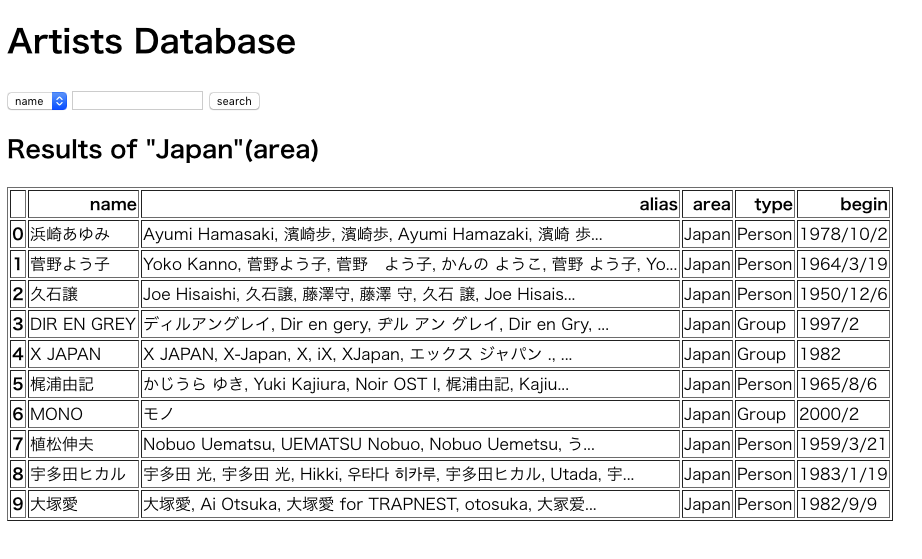

In [16]:
from IPython.display import Image
Image('./src/q69.png')